## New York City Taxi Dataset 2013

This notebook contains Data Modelling for predicting the Tip Amount for any Trip after Data Cleaning is done and both the trip data and fare data for October 2013 is merged into one dataset. For prediction I have used Neural Network models from keras and tensorflow

In [1]:
# !pip3 install seaborn

### Importing the required libraries

In [2]:
import pandas as pd

import geopy
import geopy.distance as gd
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

import matplotlib.pyplot as plt
import plotly_express as px
import seaborn as sns

import math
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

from scipy import stats

import xgboost as xg

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LeakyReLU

### Reading data from the cleaned and merged new york taxi data using pandas

In [3]:
taxi_trip_df = pd.read_csv('/data/shared/debdeep_guha/nyc_taxi_data/cleaned_full_taxi_data.csv')

In [4]:
taxi_trip_df.head()

,medallion,hack_license,vendor_id,rate_code,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,...,trip_dist_miles,trip_diff_seconds,avg_speed,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount
0,740BD5BE61840BE4FE3905CC3EBE3E7E,E48B185060FB0FF49BE6DA43E69E624B,CMT,1,2013-10-01 12:44:29,2013-10-01 12:53:26,1,536,1.2,-73.974319,...,0.884191,537.0,8.044693,CRD,8.0,0.0,0.5,2.1,0.0,10.6
1,EA05309C30F375695F44C96108ACB10F,1D10D8AC5B07D80861761365A05A9AE2,CMT,1,2013-10-02 19:44:55,2013-10-02 20:03:55,1,1139,5.1,-73.981239,...,2.075469,1140.0,16.105263,CRD,18.0,1.0,0.5,3.0,0.0,22.5
2,EA05309C30F375695F44C96108ACB10F,1D10D8AC5B07D80861761365A05A9AE2,CMT,1,2013-10-02 22:01:18,2013-10-02 22:09:18,1,480,2.2,-74.002991,...,0.454633,480.0,16.500000,CRD,9.5,0.5,0.5,2.1,0.0,12.6
3,B36D7AB5B422EA1A0588EFD1D8155EF3,669F420B42A0739A5D1058184AD227ED,CMT,1,2013-10-03 12:14:35,2013-10-03 12:26:04,1,689,0.9,-73.967178,...,0.889170,689.0,4.702467,CRD,8.5,0.0,0.5,1.8,0.0,10.8
4,28172009F5513B25F4091C0929C4515D,ABE08BCFEBF3F5F7339CA2170EEC1DEE,CMT,1,2013-10-02 00:33:37,2013-10-02 01:06:16,1,1959,14.8,-73.784142,...,10.234611,1959.0,27.197550,CRD,43.0,0.5,0.5,11.0,0.0,55.0


In [5]:
# checking the column names in the dataset
taxi_trip_df.columns

Index(['medallion', 'hack_license', 'vendor_id', 'rate_code',
       'pickup_datetime', 'dropoff_datetime', 'passenger_count',
       'trip_time_in_secs', 'trip_distance', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'trip_dist_miles', 'trip_diff_seconds', 'avg_speed', 'payment_type',
       'fare_amount', 'surcharge', 'mta_tax', 'tip_amount', 'tolls_amount',
       'total_amount'],
      dtype='object')

In [6]:
# checking the length of the dataset
len(taxi_trip_df)

13895209

In [7]:
# the datatypes of all the columns in the dataset
taxi_trip_df.dtypes

medallion             object
hack_license          object
vendor_id             object
rate_code              int64
pickup_datetime       object
dropoff_datetime      object
passenger_count        int64
trip_time_in_secs      int64
trip_distance        float64
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
trip_dist_miles      float64
trip_diff_seconds    float64
avg_speed            float64
payment_type          object
fare_amount          float64
surcharge            float64
mta_tax              float64
tip_amount           float64
tolls_amount         float64
total_amount         float64
dtype: object

#### Converting `dropoff_datetime` and `pickup_datetime` into datetime from type object

In [8]:
taxi_trip_df['dropoff_datetime'] =  pd.to_datetime(taxi_trip_df['dropoff_datetime'], format='%Y-%m-%d %H:%M:%S')
taxi_trip_df['pickup_datetime'] =  pd.to_datetime(taxi_trip_df['pickup_datetime'], format='%Y-%m-%d %H:%M:%S')

#### Extracting the day, hour and weekday number

In [9]:
taxi_trip_df['pickup_weekday'] = taxi_trip_df['pickup_datetime'].dt.dayofweek
taxi_trip_df['pickup_hour'] = taxi_trip_df['pickup_datetime'].dt.hour
taxi_trip_df['pickup_day'] = taxi_trip_df['pickup_datetime'].dt.day

#### Fare Amount Distribution

/home/ml/.local/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



Text(0.5, 0, 'Tip Amount Distribution')

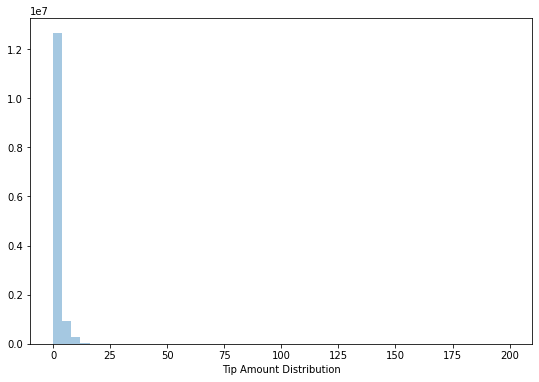

In [10]:
fig, ax = plt.subplots(figsize=(9,6))
ax = sns.distplot(taxi_trip_df['tip_amount'], kde=False)
ax.set_xlabel('Tip Amount Distribution')

In [11]:
# checking the maximum tip amount
taxi_trip_df['tip_amount'].max()

200.0

In [12]:
# checking other values for the maximum tip amount
taxi_trip_df[taxi_trip_df['tip_amount'] == taxi_trip_df['tip_amount'].max()]

,medallion,hack_license,vendor_id,rate_code,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,...,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount,pickup_weekday,pickup_hour,pickup_day
1223298,F3A913CC354E35ADB9E8E6A4BF43911F,8EDA9B7BB63ADD253F68A8F659214263,CMT,1,2013-10-17 02:11:25,2013-10-17 02:23:27,2,721,4.10,-74.004730,...,CRD,14.5,0.5,0.5,200.0,0.0,215.5,3,2,17
5143843,7DC94D55F3452BCD3EDFD35F1BA02197,F49A5C173761402FE4959E4ADBB42EB0,CMT,1,2013-10-05 03:08:27,2013-10-05 03:13:26,1,298,1.10,-73.954659,...,CRD,6.5,0.5,0.5,200.0,0.0,207.5,5,3,5
6814262,66FF15C9D7FCB6C429821DF00FABE051,190F7CD2701FF548F636E8A5D581709B,VTS,1,2013-10-07 05:57:00,2013-10-07 06:25:00,5,1680,5.49,-73.990112,...,CRD,25.0,0.5,0.5,200.0,0.0,226.0,0,5,7


In [13]:
# checking the top 50 highest fare amount values
taxi_trip_df.sort_values(by=['fare_amount'], ascending=False)['total_amount'].head(50)

12931885    480.00
13122835    450.01
2549028     450.01
9072835     450.00
6547134     479.50
11683802    450.50
9777392     424.11
295038      385.00
8701168     380.50
13654879    375.00
10518088    370.00
336286      360.00
3484026     350.00
4048436     350.00
6050315     325.00
533386      326.33
8890412     300.00
3671056     300.00
1969898     315.00
10486355    300.50
4616019     300.64
2557831     280.00
5526420     336.00
12774741    350.00
5393949     336.00
3053796     275.00
5432854     270.00
3734727     259.25
12389903    255.33
5196860     258.71
365482      240.00
5010480     250.75
1522900     284.40
8129431     241.83
785089      233.00
7754389     280.00
6177601     225.00
1929962     238.25
6188218     238.30
1234514     264.00
4417664     225.33
8467868     242.00
2820307     245.32
13057037    215.50
4249421     224.33
11786347    228.50
9032641     210.25
2674588     230.66
2051583     200.00
5751836     200.50
Name: total_amount, dtype: float64

#### The boxplot below for 'fare_amount' and 'tip_amount' shows a lot of outliers. 

(I am only removing records for which the fare amount is greater than the 4th standard deviation, this is because there are already a lot of records where Tip Amount is 0 and some records with ridiculously high Tip Amounts. We can say that most people don't like to Tip and very few like to over Tip, if that is a thing. Hence removing outliers based on the fare amount)

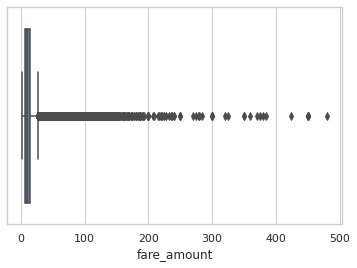

In [14]:
sns.set_theme(style="whitegrid")
ax = sns.boxplot(x=taxi_trip_df["fare_amount"])

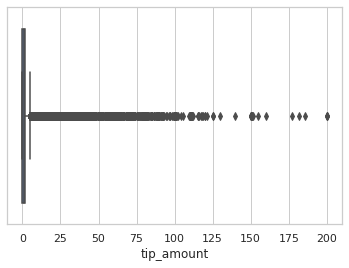

In [15]:
sns.set_theme(style="whitegrid")
ax = sns.boxplot(x=taxi_trip_df["tip_amount"])

In [16]:
# if we select records where trip amount is greater than the 4th standard deviation values, 
# we might loose out on records which have legit tip amounts
taxi_trip_df[(np.abs(stats.zscore(taxi_trip_df['tip_amount'])) > 4)]

,medallion,hack_license,vendor_id,rate_code,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,...,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount,pickup_weekday,pickup_hour,pickup_day
4,28172009F5513B25F4091C0929C4515D,ABE08BCFEBF3F5F7339CA2170EEC1DEE,CMT,1,2013-10-02 00:33:37,2013-10-02 01:06:16,1,1959,14.8,-73.784142,...,CRD,43.0,0.5,0.5,11.00,0.00,55.00,2,0,2
8,4E67DD5E52DAD3CC9F8C84132F96AD2D,B189EAD638D515A2DAD3CC8B268A3FEF,CMT,2,2013-10-02 17:07:05,2013-10-02 18:04:13,1,3427,17.5,-73.992241,...,CRD,52.0,0.0,0.5,11.56,5.33,69.39,2,17,2
55,4189F914006587B29C9822074FBD6AAE,9C98405D707D0F298AE7CDC51AE57AF1,CMT,1,2013-10-01 22:05:50,2013-10-01 22:32:02,1,1571,11.3,-73.975067,...,CRD,33.5,0.5,0.5,11.08,2.44,48.02,1,22,1
63,1957C320398402AD3EAFA9689130DF32,A1B20AA208FAAF5CDE77C4439DA3EBC3,CMT,2,2013-10-03 14:33:07,2013-10-03 15:30:24,3,3436,22.4,-74.001328,...,CRD,52.0,0.0,0.5,14.45,5.33,72.28,3,14,3
143,B57DAB9DF7583F73D85E1099C39BF983,B6D019A3A9B07E3AF1F7482D6CEC661A,CMT,2,2013-10-12 06:11:38,2013-10-12 06:42:37,1,1858,19.8,-74.005089,...,CRD,52.0,0.0,0.5,12.00,0.00,64.50,5,6,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13895043,D3970A1C3AF9805CA0DCAACD48A31632,B8212B22999F5F5A6F602AD9C2978B9C,CMT,2,2013-10-07 14:09:41,2013-10-07 15:05:29,1,3347,16.9,-73.989136,...,CRD,52.0,0.0,0.5,14.45,5.33,72.28,0,14,7
13895057,76BBABBE9C55F57536ACE694B5CD170D,628B5AF49DF6CCC9D079B378861AD8FD,CMT,1,2013-10-13 04:21:41,2013-10-13 04:43:48,2,1327,6.3,-73.997467,...,CRD,21.5,0.5,0.5,15.00,8.25,45.75,6,4,13
13895064,DF755C55F5ACD572F42038CE806B6ABE,D725209F9807FC78365C422509244AE5,CMT,2,2013-10-10 06:53:41,2013-10-10 08:04:16,1,4237,19.6,-73.781250,...,CRD,52.0,0.0,0.5,11.56,5.33,69.39,3,6,10
13895077,275648DFDA51B919B4943A3470427DEC,63A1C371CC9D9FA0A8CC9786328C64BE,CMT,2,2013-10-13 13:37:50,2013-10-13 14:23:47,3,2756,17.3,-73.978928,...,CRD,52.0,0.0,0.5,14.45,5.33,72.28,6,13,13


In [17]:
# checking the number of records that will be removed if stdev of 4 is selected
taxi_trip_df[(np.abs(stats.zscore(taxi_trip_df['fare_amount'])) > 4)]

,medallion,hack_license,vendor_id,rate_code,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,...,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount,pickup_weekday,pickup_hour,pickup_day
189,FB44AC801A5E0C646781C90C3F9DFB56,11A6677A48CF6D3C17FA3F18AD4A68AC,CMT,3,2013-10-10 16:37:07,2013-10-10 17:17:49,1,2442,17.0,-73.980911,...,CRD,67.5,1.0,0.0,15.20,16.30,100.00,3,16,10
221,F605E00E7F30EA8A192451B8C3558DF2,5FC6FB04951DC550B958E6CDC1F0B992,CMT,1,2013-10-12 15:21:38,2013-10-12 16:19:59,1,3500,25.4,-74.008965,...,CRD,72.5,0.0,0.5,14.60,0.00,87.60,5,15,12
940,3519845B181E2C0C603FF23A320A1718,DF46CE34589E2AA3251F4F55DC80C71A,CMT,3,2013-10-09 11:42:40,2013-10-09 12:38:49,1,3369,18.9,-73.965759,...,CRD,80.0,0.0,0.0,15.00,12.85,107.85,2,11,9
975,5DB04ACE041C02E42BC57A25FF037AFA,6972A2B75B1963488B944F9B956D50A1,CMT,1,2013-10-08 16:13:29,2013-10-08 17:37:53,2,5064,10.7,-73.985573,...,CRD,58.5,1.0,0.5,12.00,0.00,72.00,1,16,8
1051,1573B667872D77E8130DB3A06A6975A7,30D8804C7CC2FD096389A05C3D29CB26,CMT,1,2013-10-13 13:56:35,2013-10-13 14:43:20,1,2805,19.3,-73.788979,...,CRD,54.0,0.0,0.5,13.62,0.00,68.12,6,13,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13894688,AA61AF12089DFE53ED13E67F0A42120A,2C584442C9DC6740767CDE5672C12379,CMT,1,2013-10-09 23:37:03,2013-10-10 00:11:15,1,2051,19.2,-73.982285,...,CRD,53.5,0.5,0.5,15.50,7.50,77.50,2,23,9
13894718,DBA15F7F35F853A32486CE789D7C0499,3871B106F70A201F76E2E82A5C0735DF,CMT,5,2013-10-10 23:08:38,2013-10-10 23:18:57,1,618,3.3,-73.997696,...,CRD,60.0,0.0,0.0,0.00,0.00,60.00,3,23,10
13894795,F09F782FAC8A0139ED3ACCB1AABA0689,A16383213C8C356120F2436E26963C40,CMT,5,2013-10-07 22:57:38,2013-10-07 23:14:29,1,1010,6.1,-73.984978,...,CRD,55.0,0.0,0.0,0.00,10.00,65.00,0,22,7
13895111,FE03F0961C73A4589ED4C40DFC60E771,90460D3132B627B0D04B17CA8DE772B9,CMT,1,2013-10-09 21:08:17,2013-10-09 21:43:21,1,2104,23.0,-73.776848,...,CRD,61.0,0.5,0.5,10.00,0.00,72.00,2,21,9


In [18]:
# records with 0 tip amount
taxi_trip_df[taxi_trip_df['tip_amount'] == 0]

,medallion,hack_license,vendor_id,rate_code,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,...,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount,pickup_weekday,pickup_hour,pickup_day
109,693258BB6AE8D76A83FC045FD7ECA76A,EBD0AD2945D84BD3BEF708DE3F209320,CMT,1,2013-10-05 05:17:43,2013-10-05 05:22:15,1,271,0.8,-74.005348,...,CRD,5.0,0.5,0.5,0.0,0.00,6.00,5,5,5
166,3D358773BB4D5FF7F6B2B915AF8965CB,58BEA0106F5D76C318B2663F9101A277,CMT,1,2013-10-07 01:26:12,2013-10-07 01:33:01,1,409,0.7,-73.987694,...,CRD,6.5,0.5,0.5,0.0,0.00,7.50,0,1,7
213,040AF8EB302E2DA63F97B99B93B81CAB,9A7FA293329B4C5F1D646783813CD4D2,CMT,1,2013-10-13 20:08:22,2013-10-13 20:34:57,1,1595,9.6,-73.999924,...,CRD,31.5,0.5,0.5,0.0,0.00,32.50,6,20,13
215,5D065820387B757289D5AD0181DEB0B4,3456B711F67C08742ED91DE76021A1A9,CMT,1,2013-10-13 10:20:54,2013-10-13 10:31:04,1,610,5.6,-73.972229,...,CRD,17.0,0.0,0.5,0.0,0.00,17.50,6,10,13
310,F6CBA8F054A17F0D2C6F1F15B4CC75AB,46DF729B2CE4EEE0FD0950E200419A67,CMT,1,2013-10-13 21:42:09,2013-10-13 22:41:34,1,3564,9.1,-73.991188,...,CRD,42.0,0.5,0.5,0.0,0.00,43.00,6,21,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13894895,C3A871595B3A82C6745C034CF1CB6F35,B59A7789BC0E46AD69F87571BC5726C1,CMT,1,2013-10-07 01:31:13,2013-10-07 01:36:33,2,319,1.4,-73.992020,...,CRD,6.5,0.5,0.5,0.0,0.00,7.50,0,1,7
13894960,05B5B0310C6F2F6A8D556547C1E18135,7BD86A34E5C7BBC60C14430BCAB54C40,CMT,1,2013-10-10 11:52:36,2013-10-10 12:01:00,1,504,1.4,-73.947510,...,CRD,8.0,0.0,0.5,0.0,0.00,8.50,3,11,10
13895059,8AD1BA68758C25DB8B45C954A3266D7C,5A733524AD92CA2525182D59E7E7BB83,CMT,1,2013-10-07 22:31:30,2013-10-07 22:38:21,1,411,1.6,-74.000862,...,CRD,7.0,0.5,0.5,0.0,0.00,8.00,0,22,7
13895060,3F0E768DAA2BC7BB4E7A017728B10750,3B180C434C22B6F61EA13DDE5C3B6D9D,CMT,1,2013-10-07 12:23:12,2013-10-07 12:54:50,1,1897,10.7,-73.998672,...,CRD,34.5,0.0,0.5,0.0,5.33,40.33,0,12,7


In [19]:
# basically removing records with fare_amount more than 52.5$
upd_taxi_trip_df = taxi_trip_df[(np.abs(stats.zscore(taxi_trip_df['fare_amount'])) < 4)]

In [20]:
upd_taxi_trip_df.reset_index(drop=True, inplace=True)

In [21]:
upd_taxi_trip_df

,medallion,hack_license,vendor_id,rate_code,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,...,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount,pickup_weekday,pickup_hour,pickup_day
0,740BD5BE61840BE4FE3905CC3EBE3E7E,E48B185060FB0FF49BE6DA43E69E624B,CMT,1,2013-10-01 12:44:29,2013-10-01 12:53:26,1,536,1.2,-73.974319,...,CRD,8.0,0.0,0.5,2.10,0.0,10.60,1,12,1
1,EA05309C30F375695F44C96108ACB10F,1D10D8AC5B07D80861761365A05A9AE2,CMT,1,2013-10-02 19:44:55,2013-10-02 20:03:55,1,1139,5.1,-73.981239,...,CRD,18.0,1.0,0.5,3.00,0.0,22.50,2,19,2
2,EA05309C30F375695F44C96108ACB10F,1D10D8AC5B07D80861761365A05A9AE2,CMT,1,2013-10-02 22:01:18,2013-10-02 22:09:18,1,480,2.2,-74.002991,...,CRD,9.5,0.5,0.5,2.10,0.0,12.60,2,22,2
3,B36D7AB5B422EA1A0588EFD1D8155EF3,669F420B42A0739A5D1058184AD227ED,CMT,1,2013-10-03 12:14:35,2013-10-03 12:26:04,1,689,0.9,-73.967178,...,CRD,8.5,0.0,0.5,1.80,0.0,10.80,3,12,3
4,28172009F5513B25F4091C0929C4515D,ABE08BCFEBF3F5F7339CA2170EEC1DEE,CMT,1,2013-10-02 00:33:37,2013-10-02 01:06:16,1,1959,14.8,-73.784142,...,CRD,43.0,0.5,0.5,11.00,0.0,55.00,2,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13836677,3FD555B8EA958A8AC0A50FCBEDED5CE2,A59A74F32FDFB59430AAC596A2B54FA6,CMT,1,2013-10-07 20:24:34,2013-10-07 20:30:22,1,347,1.0,-73.968300,...,CRD,6.0,0.5,0.5,1.00,0.0,8.00,0,20,7
13836678,F72C82AFFA243C164EA00B43398EDFCD,1B8B820092E36B6BDEF66B2B836A5E1F,CMT,1,2013-10-08 17:34:04,2013-10-08 17:42:27,3,502,1.1,-73.985168,...,CRD,7.0,1.0,0.5,2.10,0.0,10.60,1,17,8
13836679,400E7547B850AB2C980B02293A279988,265712C4B013561E39DA4EF5700BC8F0,CMT,1,2013-10-09 21:56:46,2013-10-09 22:03:43,1,416,1.8,-73.998978,...,CRD,8.0,0.5,0.5,1.80,0.0,10.80,2,21,9
13836680,C612423A09BF7298B817EBB674E7DC11,F3E5CC66E8544AF5FF67DFB70B6A7481,CMT,1,2013-10-10 02:11:50,2013-10-10 02:17:49,1,359,1.1,-73.985756,...,CRD,6.5,0.5,0.5,1.50,0.0,9.00,3,2,10


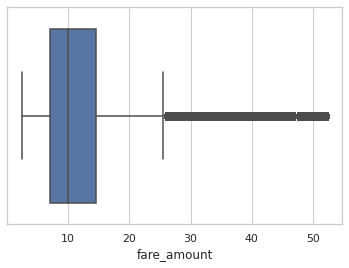

In [22]:
# a much better box plot for fare amount
sns.set_theme(style="whitegrid")
ax = sns.boxplot(x=upd_taxi_trip_df["fare_amount"])

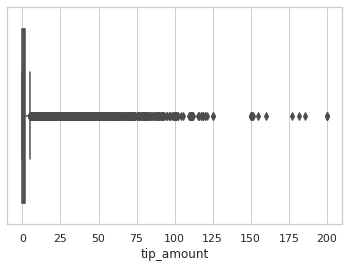

In [23]:
# the tip amount still looks the same
sns.set_theme(style="whitegrid")
ax = sns.boxplot(x=upd_taxi_trip_df["tip_amount"])

/home/ml/.local/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



Text(0.5, 0, 'Tip Amount Distribution')

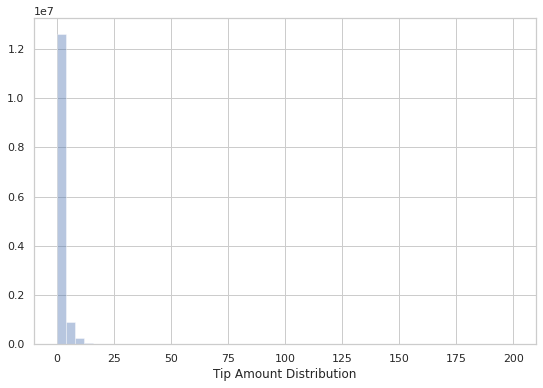

In [24]:
# checking the distribution after removing those records
fig, ax = plt.subplots(figsize=(9,6))
ax = sns.distplot(upd_taxi_trip_df['tip_amount'], kde=False)
ax.set_xlabel('Tip Amount Distribution')

### Feature Importance using Correlation

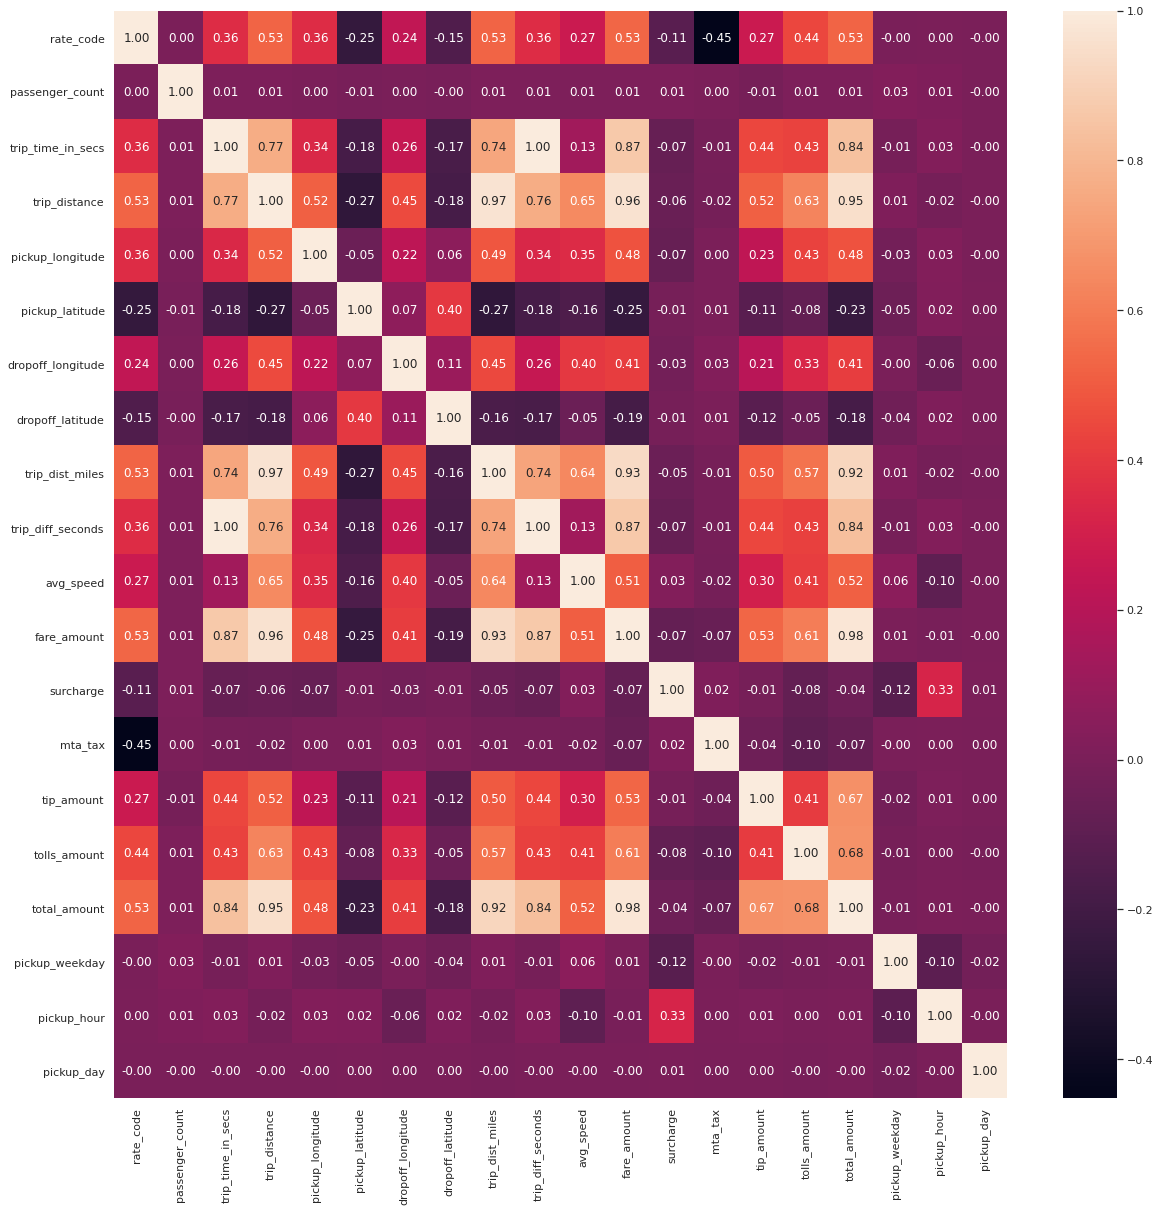

In [25]:
fig, ax = plt.subplots(figsize=(20,20))  
sns.heatmap(upd_taxi_trip_df.corr(), annot=True, fmt=".2f", ax=ax)
plt.show()

The most important features for predicting tip amount are (correlation value greater than 0.5):
- trip_distance (The distance travelled between pickup and dropoff locations)
- fare_amount (The fare amount incurred for the trip)
- total_amount ( The total amount incurred for the trip)

We may have to remove `total_amount` from the features as it might be too influential in predicting the `tip_amount`. `total_amount` is basically the summation of all the amounts incurred as part of the trip.

### Feature Engineering

Here we have to remove certain unnecessary columns, convert categorical columns into dummy columns (like one-hot encoding them), scale all the numerical columns within a certain range.

In [26]:
upd_taxi_trip_df.columns

Index(['medallion', 'hack_license', 'vendor_id', 'rate_code',
       'pickup_datetime', 'dropoff_datetime', 'passenger_count',
       'trip_time_in_secs', 'trip_distance', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'trip_dist_miles', 'trip_diff_seconds', 'avg_speed', 'payment_type',
       'fare_amount', 'surcharge', 'mta_tax', 'tip_amount', 'tolls_amount',
       'total_amount', 'pickup_weekday', 'pickup_hour', 'pickup_day'],
      dtype='object')

In [27]:
for cols in upd_taxi_trip_df.columns:
    print('Number of unique values in %s is %s' %(cols, len(upd_taxi_trip_df[cols].unique())))

Number of unique values in medallion is 13299
Number of unique values in hack_license is 33191
Number of unique values in vendor_id is 2
Number of unique values in rate_code is 6
Number of unique values in pickup_datetime is 2279355
Number of unique values in dropoff_datetime is 2281415
Number of unique values in passenger_count is 6
Number of unique values in trip_time_in_secs is 6787
Number of unique values in trip_distance is 3391
Number of unique values in pickup_longitude is 31849
Number of unique values in pickup_latitude is 59571
Number of unique values in dropoff_longitude is 44230
Number of unique values in dropoff_latitude is 82196
Number of unique values in trip_dist_miles is 13758563
Number of unique values in trip_diff_seconds is 7092
Number of unique values in avg_speed is 303201
Number of unique values in payment_type is 5
Number of unique values in fare_amount is 232
Number of unique values in surcharge is 28
Number of unique values in mta_tax is 2
Number of unique valu

#### Dropping 'medallion', 'hack_license', 'pickup_datetime', 'dropoff_datetime', 'trip_time_in_secs', 'trip_dist_miles' columns

In [28]:
drop_columns = ['medallion', 'hack_license', 'pickup_datetime', 'dropoff_datetime', 'trip_time_in_secs', 'trip_dist_miles']
upd_taxi_trip_df = upd_taxi_trip_df.drop(drop_columns, axis = 1)

In [29]:
upd_taxi_trip_df.columns

Index(['vendor_id', 'rate_code', 'passenger_count', 'trip_distance',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'trip_diff_seconds', 'avg_speed', 'payment_type',
       'fare_amount', 'surcharge', 'mta_tax', 'tip_amount', 'tolls_amount',
       'total_amount', 'pickup_weekday', 'pickup_hour', 'pickup_day'],
      dtype='object')

In [30]:
upd_taxi_trip_df.dtypes

vendor_id             object
rate_code              int64
passenger_count        int64
trip_distance        float64
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
trip_diff_seconds    float64
avg_speed            float64
payment_type          object
fare_amount          float64
surcharge            float64
mta_tax              float64
tip_amount           float64
tolls_amount         float64
total_amount         float64
pickup_weekday         int64
pickup_hour            int64
pickup_day             int64
dtype: object

#### Converting 'vendor_id', 'rate_code', 'passenger_count', 'payment_type', 'pickup_weekday', 'pickup_hour', 'pickup_day' into dummy variables

In [31]:
categorical_columns = ['vendor_id', 'rate_code', 'passenger_count', 'payment_type', 'pickup_weekday', 'pickup_hour', 
                       'pickup_day']

upd_taxi_trip_df = pd.get_dummies(upd_taxi_trip_df, columns=categorical_columns)

In [32]:
upd_taxi_trip_df.columns

Index(['trip_distance', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'trip_diff_seconds',
       'avg_speed', 'fare_amount', 'surcharge', 'mta_tax', 'tip_amount',
       'tolls_amount', 'total_amount', 'vendor_id_CMT', 'vendor_id_VTS',
       'rate_code_1', 'rate_code_2', 'rate_code_3', 'rate_code_4',
       'rate_code_5', 'rate_code_6', 'passenger_count_1', 'passenger_count_2',
       'passenger_count_3', 'passenger_count_4', 'passenger_count_5',
       'passenger_count_6', 'payment_type_CRD', 'payment_type_CSH',
       'payment_type_DIS', 'payment_type_NOC', 'payment_type_UNK',
       'pickup_weekday_0', 'pickup_weekday_1', 'pickup_weekday_2',
       'pickup_weekday_3', 'pickup_weekday_4', 'pickup_weekday_5',
       'pickup_weekday_6', 'pickup_hour_0', 'pickup_hour_1', 'pickup_hour_2',
       'pickup_hour_3', 'pickup_hour_4', 'pickup_hour_5', 'pickup_hour_6',
       'pickup_hour_7', 'pickup_hour_8', 'pickup_hour_9', 'pickup_hour_10',
       '

#### Scaling numerical columns using MinMax Scalar (except for the `Tip Amount`)

In [33]:
scaler = MinMaxScaler()

In [34]:
numerical_columns = ['trip_distance', 'trip_diff_seconds', 'avg_speed', 'surcharge', 'mta_tax', 
                     'fare_amount', 'tolls_amount', 'total_amount']

upd_taxi_trip_df[numerical_columns] = scaler.fit_transform(upd_taxi_trip_df[numerical_columns])

### Creating Training and Testing Dataset

In [35]:
X = upd_taxi_trip_df.drop(columns=['tip_amount'])
y = upd_taxi_trip_df['tip_amount']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#### Building a Neural Network Model

In [36]:
dnn_model = Sequential()
dnn_model.add(Dense(32, activation='relu', input_shape=(len(X_train.columns),)))
dnn_model.add(Dense(32, activation='relu'))
dnn_model.add(Dense(32, activation='relu'))
dnn_model.add(Dense(1, activation='linear'))

In [37]:
dnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                3008      
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 5,153
Trainable params: 5,153
Non-trainable params: 0
_________________________________________________________________


#### Compiling the Neural Network Model and fitting it on Training Data

In [38]:
dnn_model.compile(loss='mean_squared_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

In [39]:
history = dnn_model.fit(
            X_train, y_train,
            validation_split=0.2,
            batch_size = 50000,
            callbacks=[callback],
            verbose=1, epochs=100)

Epoch 1/100
155/155 [==============================] - 4s 22ms/step - loss: 13.7453 - val_loss: 4.3421
Epoch 2/100
155/155 [==============================] - 2s 14ms/step - loss: 4.2232 - val_loss: 3.7868
Epoch 3/100
155/155 [==============================] - 2s 14ms/step - loss: 3.6086 - val_loss: 2.8147
Epoch 4/100
155/155 [==============================] - 2s 14ms/step - loss: 2.4747 - val_loss: 1.7703
Epoch 5/100
155/155 [==============================] - 2s 14ms/step - loss: 1.6896 - val_loss: 1.4360
Epoch 6/100
155/155 [==============================] - 2s 14ms/step - loss: 1.3997 - val_loss: 1.2491
Epoch 7/100
155/155 [==============================] - 2s 14ms/step - loss: 1.2700 - val_loss: 1.1468
Epoch 8/100
155/155 [==============================] - 2s 14ms/step - loss: 1.1587 - val_loss: 1.1159
Epoch 9/100
155/155 [==============================] - 2s 14ms/step - loss: 1.1224 - val_loss: 1.1970
Epoch 10/100
155/155 [==============================] - 2s 14ms/step - loss: 1.09

In [40]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([0, 12])
    plt.xlabel('Epoch')
    plt.ylabel('Error tip_amount')
    plt.legend()
    plt.grid(True)

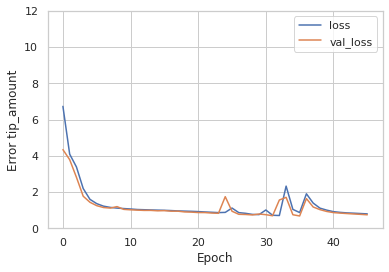

In [41]:
plot_loss(history)

#### Evaluating it on Testing Data

In [42]:
dnn_model.evaluate(X_test, y_test, verbose=1)

129719/129719 [==============================] - 58s 447us/step - loss: 0.7687


0.7687028646469116

In [43]:
y_pred = dnn_model.predict(X_test).flatten()

# Display metrics
mse = mean_squared_error(y_test, y_pred)
print("MSE:", mse)
print("RMSE: %.3f" % np.sqrt(mse))
r2 = r2_score(y_test, y_pred)
print("R2:", r2)

MSE: 0.7687134540881206
RMSE: 0.877
R2: 0.832297041111519


### Running the Neural Network Model without `total_amount`

In [52]:
X = upd_taxi_trip_df.drop(columns=['tip_amount', 'total_amount'])
y = upd_taxi_trip_df['tip_amount']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [53]:
dnn_model_upd = Sequential()
dnn_model_upd.add(Dense(32, activation='relu', input_shape=(len(X_train.columns),)))
dnn_model_upd.add(Dense(32, activation='relu'))
dnn_model_upd.add(Dense(32, activation='relu'))
dnn_model_upd.add(Dense(1, activation='linear'))

In [54]:
dnn_model_upd.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 32)                2976      
_________________________________________________________________
dense_9 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_10 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 33        
Total params: 5,121
Trainable params: 5,121
Non-trainable params: 0
_________________________________________________________________


#### Compiling the Neural Network Model and fitting it on Training Data

In [55]:
dnn_model_upd.compile(loss='mean_squared_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

In [56]:
history_upd = dnn_model_upd.fit(
            X_train, y_train,
            validation_split=0.2,
            batch_size = 50000,
            callbacks=[callback],
            verbose=1, epochs=100)

Epoch 1/100
155/155 [==============================] - 4s 20ms/step - loss: 4.4697 - val_loss: 2.8287
Epoch 2/100
155/155 [==============================] - 2s 14ms/step - loss: 2.3210 - val_loss: 1.7896
Epoch 3/100
155/155 [==============================] - 2s 14ms/step - loss: 1.7700 - val_loss: 1.6031
Epoch 4/100
155/155 [==============================] - 2s 14ms/step - loss: 1.5465 - val_loss: 1.3877
Epoch 5/100
155/155 [==============================] - 2s 14ms/step - loss: 1.3837 - val_loss: 1.3367
Epoch 6/100
155/155 [==============================] - 2s 14ms/step - loss: 1.2824 - val_loss: 1.1692
Epoch 7/100
155/155 [==============================] - 2s 14ms/step - loss: 1.1710 - val_loss: 1.1293
Epoch 8/100
155/155 [==============================] - 2s 14ms/step - loss: 1.1869 - val_loss: 1.1367
Epoch 9/100
155/155 [==============================] - 2s 14ms/step - loss: 1.1601 - val_loss: 1.0962
Epoch 10/100
155/155 [==============================] - 2s 14ms/step - loss: 1.126

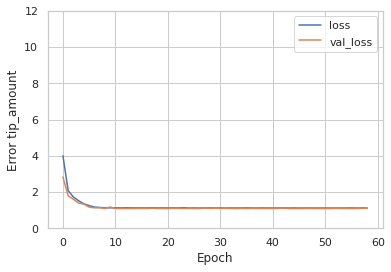

In [57]:
plot_loss(history_upd)

#### Evaluating it on Testing Data

In [58]:
dnn_model_upd.evaluate(X_test, y_test, verbose=1)

129719/129719 [==============================] - 58s 447us/step - loss: 1.1409


1.1408908367156982

In [59]:
y_pred = dnn_model_upd.predict(X_test).flatten()

# Display metrics
mse = mean_squared_error(y_test, y_pred)
print("MSE:", mse)
print("RMSE: %.3f" % np.sqrt(mse))
r2 = r2_score(y_test, y_pred)
print("R2:", r2)

MSE: 1.1408942029189946
RMSE: 1.068
R2: 0.7511018799128533
